# Створення базових моделей

**Частина 1**

Необхідно визначити в коді натупне:

1. Базову модель для навчання (виберіть який тип моделі хочете натренувати CNN, MLP тощо).
2. Початкову кількість шарів та їх параметри.
3. Функції для тренування та валідації, візуалізації результатів, фінкцію втрат та метрику перевірки результатів.
4. Натренуйте модель і перевірте результат. Яке значення функції втрат, яка метрика вашої моделі після навчання? Візуалізуйте графіки навчання. Скільки часу потрібно було на тренування?

**Частина 2**

1. Опишіть гіперпараметри моделі: кількість шарів/кількість нейронів в шарах, різні їх комбінації.
2. Підберіть та перевірте найкращі гіперпараметри вашої моделі за яких метрика під час валідації буде найвищою. Скільки часу потрібно було на підбір гіперпараметрів моделі?
3. Продемонструйте на яких класах та зображеннях найчастіше помиляється найкраща модель.
4. Візуалізувати графіки залежностей між гіперпараметрами найкращої моделі і змінами значень її метрики.

In [2]:
%pip install optuna torch matplotlib torchvision plotly pandas


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

In [3]:
import os

import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms


DEVICE = torch.device("cpu")
BATCHSIZE = 128
CLASSES = 10
DIR = os.getcwd()
EPOCHS = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10


/Users/mp/.pyenv/versions/3.10.10/envs/kma-nn-3.10.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

def get_mnist():
    # Load FashionMNIST dataset.
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(DIR, train=True, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(DIR, train=False, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )

    return train_loader, valid_loader



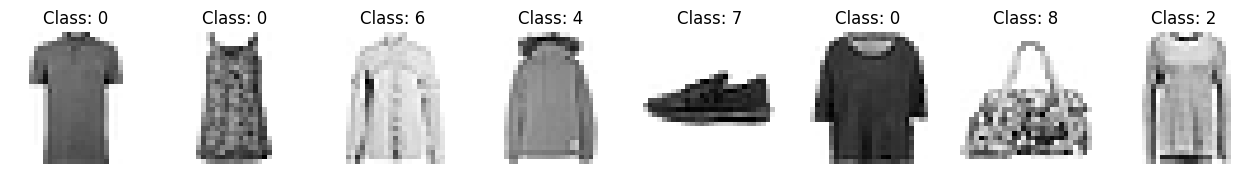

In [5]:
train_loader, valid_loader = get_mnist()
plt_size = 2
plt_images = 8
IMAGE_SIZE = 28

for (X_train, y_train) in train_loader:
    plt.figure(figsize=(plt_images * plt_size, plt_size))

    for i in range(plt_images):
        plt.subplot(1, plt_images, i + 1)
        plt.axis('off')
        plt.imshow(X_train[i, :, :, :].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray_r")
        plt.title(f'Class: {y_train[i].item()}')

    break

In [6]:
class MyNN(torch.nn.Module):
  def __init__(self) -> None:
    super(MyNN, self).__init__()
    conv_kernel_3 = 3
    pool_kernel_2 = 2

    in_features = 1
    out_features = 24
    image_size = [IMAGE_SIZE, IMAGE_SIZE]

    self.conv = torch.nn.Conv2d(in_features, out_features, kernel_size=conv_kernel_3, stride=1, padding=(conv_kernel_3 - 1) // 2)
    self.relu = torch.nn.ReLU()
    self.pool = torch.nn.MaxPool2d(kernel_size=pool_kernel_2, stride=pool_kernel_2)

    in_features = out_features
    image_size[0] //= pool_kernel_2
    image_size[1] //= pool_kernel_2

    self.flatten = nn.Flatten()
    self.relu_out = nn.ReLU()
    self.fc = torch.nn.Linear(in_features * image_size[0] * image_size[1], CLASSES_N)
    self.sm = torch.nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.conv(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.flatten(x)
    x = self.relu_out(x)
    x = self.fc(x)
    x = self.sm(x)
    return x


In [19]:
avg_accuracies = []
avg_losses = []

In [20]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)



In [21]:
def objective(trial):
    global avg_accuracies, avg_losses

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_mnist()

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        running_loss = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                running_loss += loss.item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)
        average_loss = running_loss / len(train_loader)

        avg_accuracies.append(accuracy)
        avg_losses.append(average_loss)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy



In [26]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-11-06 09:58:05,170] A new study created in memory with name: no-name-bcab523d-6e5f-42e0-83fc-a1048c554cde
[I 2023-11-06 09:58:07,101] Trial 0 finished with value: 0.1421875 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'dropout_l0': 0.4071858391403412, 'n_units_l1': 78, 'dropout_l1': 0.3274639262024218, 'optimizer': 'SGD', 'lr': 6.363059266562789e-05}. Best is trial 0 with value: 0.1421875.
[I 2023-11-06 09:58:08,899] Trial 1 finished with value: 0.10234375 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'dropout_l0': 0.36626054251291273, 'n_units_l1': 10, 'dropout_l1': 0.23540041645289247, 'optimizer': 'SGD', 'lr': 7.119363194905997e-05}. Best is trial 0 with value: 0.1421875.
[I 2023-11-06 09:58:10,813] Trial 2 finished with value: 0.690625 and parameters: {'n_layers': 1, 'n_units_l0': 118, 'dropout_l0': 0.3250235845097512, 'optimizer': 'RMSprop', 'lr': 7.126771559706174e-05}. Best is trial 2 with value: 0.690625.
[I 2023-11-06 09:58:12,760] Trial 3 finished with value:

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  57
  Number of complete trials:  43
Best trial:
  Value:  0.85390625
  Params: 
    n_layers: 1
    n_units_l0: 113
    dropout_l0: 0.31841289283805846
    optimizer: Adam
    lr: 0.005892920564219942


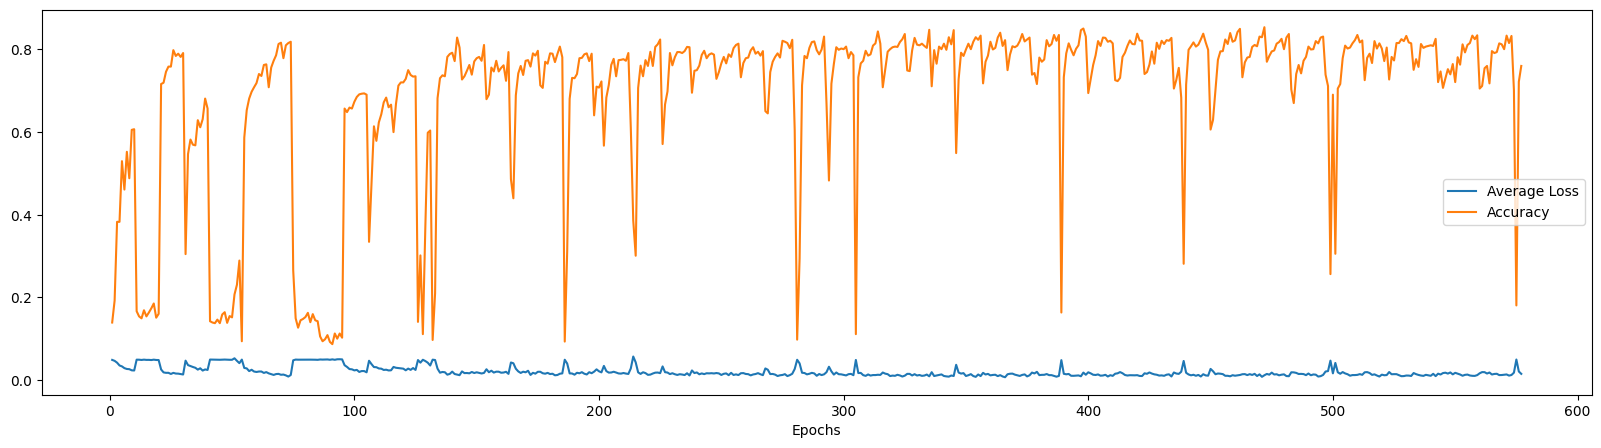

In [30]:
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(avg_losses) + 1), avg_losses, label='Average Loss')
plt.plot(range(1, len(avg_accuracies) + 1), avg_accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [31]:
import torch
import torch.nn.functional as F

best_trial = study.best_trial
best_model = define_model(best_trial)
best_model.eval()

correct = 0
total = 0
class_correct = [0 for _ in range(CLASSES)]
class_total = [0 for _ in range(CLASSES)]

with torch.no_grad():
    for data, labels in valid_loader:
        data, target = data.view(data.size(0), -1).to(DEVICE), labels.to(DEVICE)
        outputs = best_model(data)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

class_accuracy = [class_correct[i] / class_total[i] for i in range(CLASSES)]
most_unpredictable_class = class_accuracy.index(min(class_accuracy))

print(f"Most unpredictable class: {most_unpredictable_class}")
print(f"Accuracy for each class: {class_accuracy}")


Most unpredictable class: 1
Accuracy for each class: [0.987, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0]


In [32]:
from optuna.visualization import plot_optimization_history, plot_contour

best_trial = study.best_trial
plot_optimization_history(study).show(renderer="browser")
hyperparams = [f'n_units_l{i}' for i in range(2)] + ['n_layers']
plot_contour(study, params=hyperparams).show(renderer="browser")
plt.show()


![Alt Text](charts/optuna-report.png)

![Alt Text](charts/optuna-objective.png)

### JUPYTER STORES EXECUTION TIME OF EACH CELL